<a href="https://colab.research.google.com/github/menduv/Deep-Learning-Projects/blob/main/CNN_vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Loading required libraries

In [9]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os,cv2
from IPython.display import Image
from keras.preprocessing import image
from keras import optimizers
from keras import layers,models
from keras.applications.imagenet_utils import preprocess_input
import matplotlib.pyplot as plt
import seaborn as sns
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
print(os.listdir("/content/cactus"))

import numpy as np

['train.zip', 'train.csv', 'sample_submission.csv', 'test.zip', '.ipynb_checkpoints']


In [ ]:
!unzip cactus/test.zip

In [ ]:
!unzip cactus/train.zip

### Setting our directories

In [13]:
train_dir="/content/train"
test_dir="/content/test"
train=pd.read_csv('/content/cactus/train.csv')

df_test=pd.read_csv('/content/cactus/sample_submission.csv')

### Getting a basic idea

In [14]:
train.head(5)
train.has_cactus=train.has_cactus.astype(str) #why change the var type to str?

In [15]:
print('out dataset has {} rows and {} columns'.format(train.shape[0],train.shape[1]))

out dataset has 17500 rows and 2 columns


In [16]:
train['has_cactus'].value_counts()

1    13136
0     4364
Name: has_cactus, dtype: int64

In [18]:
print("The number of rows in test set is %d"%(len(os.listdir('/content/test'))))

The number of rows in test set is 4000


### Displaying an image

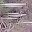

In [20]:
Image(os.path.join("/content/train",train.iloc[0,0]),width=250,height=250)

### Data preparation

In [21]:
#creating a ImageDataGenerator object
#for data augmentation; create new imgaes from the training set while training of the model
datagen=ImageDataGenerator(rescale=1./255)
batch_size=150

In the next cell a data generator is defined. A data generator is an iterator that will create batches of augmented images with a label during the training of a neural network model. It reads image files from the specified directory, reads the labels from the specified dataframe to match the image and their label. This is a common set up for training DL model with Keras.

In [22]:
train_generator=datagen.flow_from_dataframe(dataframe=train[:15000],directory=train_dir,x_col='id',
                                            y_col='has_cactus',class_mode='binary',batch_size=batch_size,
                                            target_size=(150,150))


validation_generator=datagen.flow_from_dataframe(dataframe=train[15000:],directory=train_dir,x_col='id',
                                                y_col='has_cactus',class_mode='binary',batch_size=50,
                                                target_size=(150,150))

Found 15001 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.


### Building our model

In [23]:
model=models.Sequential()
model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation='relu',input_shape=(150,150,3)))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(128,(3,3),activation='relu',input_shape=(150,150,3)))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(128,(3,3),activation='relu',input_shape=(150,150,3)))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

### Displaying summary of our network

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 17, 17, 128)      

### Compiling our model

In [26]:
model.compile(loss='binary_crossentropy',optimizer='rmsprop', metrics=['acc'])

### Fitting our model

The fit_generator method trains the model on the training data (train_generator) for a specified number of epochs, updating the model's weights based on the gradients calculated during each batch

In [29]:
epochs=1 #it take s14 minutes to run an epoch
history=model.fit_generator(train_generator,steps_per_epoch=100,epochs=epochs,validation_data=validation_generator,validation_steps=50)

<ipython-input-29-80920fb2609c>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator,steps_per_epoch=100,epochs=epochs,validation_data=validation_generator,validation_steps=50)


100/100 [==============================] - 859s 9s/step - loss: 0.2119 - acc: 0.9183 - val_loss: 0.1817 - val_acc: 0.9356


### Evaluating our model

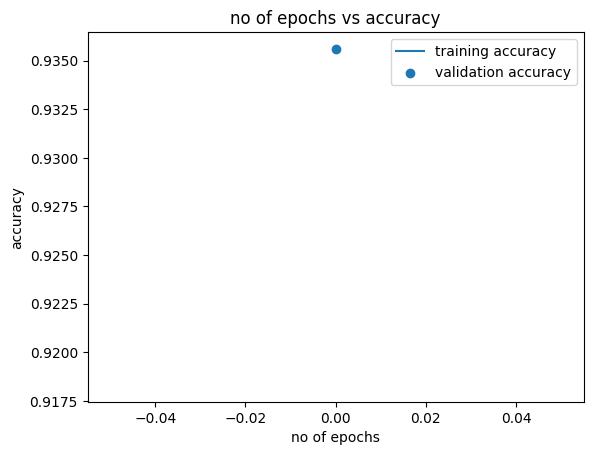

In [30]:
acc=history.history['acc']  ##getting  accuracy of each epochs
epochs_=range(0,epochs)
plt.plot(epochs_,acc,label='training accuracy')
plt.xlabel('no of epochs')
plt.ylabel('accuracy')

acc_val=history.history['val_acc']  ##getting validation accuracy of each epochs
plt.scatter(epochs_,acc_val,label="validation accuracy")
plt.title("no of epochs vs accuracy")
plt.legend()

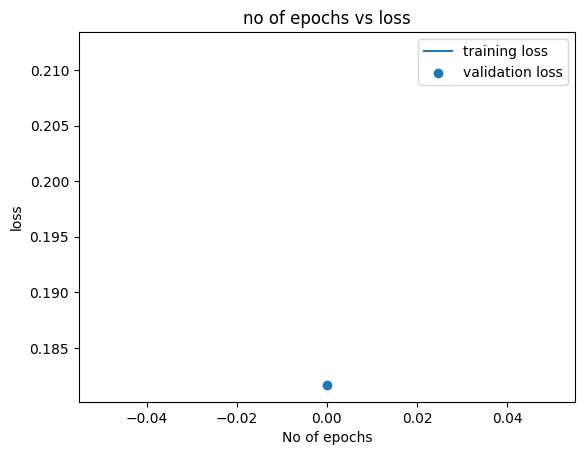

In [31]:
acc=history.history['loss']    ##getting  loss of each epochs
epochs_=range(0,epochs)
plt.plot(epochs_,acc,label='training loss')
plt.xlabel('No of epochs')
plt.ylabel('loss')

acc_val=history.history['val_loss']  ## getting validation loss of each epochs
plt.scatter(epochs_,acc_val,label="validation loss")
plt.title('no of epochs vs loss')
plt.legend()

### Improving our model using VGG16

In [32]:
model_vg=VGG16(weights='imagenet',include_top=False)
model_vg.summary()

58889256/58889256 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

### Extracting features using VGG16

In [ ]:
def extract_features(directory,samples,df):


    features=np.zeros(shape=(samples,4,4,512))
    labels=np.zeros(shape=(samples))
    generator=datagen.flow_from_dataframe(dataframe=df,directory=directory,x_col='id',
                                            y_col='has_cactus',class_mode='other',batch_size=batch_size,
                                            target_size=(150,150))
    i=0
    for input_batch,label_batch in generator:
        feature_batch=model_vg.predict(input_batch)
        features[i*batch_size:(i+1)*batch_size]=feature_batch
        labels[i*batch_size:(i+1)*batch_size]=label_batch
        i+=1
        if(i*batch_size>samples):
            break
    return(features,labels)

train.has_cactus=train.has_cactus.astype(int)
features,labels=extract_features(train_dir,17500,train)
train_features=features[:15001]
train_labels=labels[:15001]

validation_features=features[15000:]
validation_labels=labels[15000:]

Found 17500 validated image filenames.
4/5 [=======================>......] - ETA: 8s 

### Reshaping our features to feed into our dense layers

In [38]:
#df_test.has_cactus=df_test.has_cactus.astype(str)
test_features,test_labels=extract_features(test_dir,4000,df_test)

Found 4000 validated image filenames.
4/4 [==============================] - 27s 6s/step


In [39]:
train_features=train_features.reshape((15001,4*4*512))
validation_features=validation_features.reshape((2500,4*4*512))

test_features=test_features.reshape((4000,4*4*512))

### Define a densely connected network

In [40]:
model=models.Sequential()
model.add(layers.Dense(212,activation='relu',kernel_regularizer=regularizers.l1_l2(.001),input_dim=(4*4*512)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1,activation='sigmoid'))

In [42]:
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])

In [43]:
history=model.fit(train_features,train_labels,epochs=1,batch_size=15,validation_data=(validation_features,validation_labels))

1001/1001 [==============================] - 38s 38ms/step - loss: 1.4706 - acc: 0.8969 - val_loss: 1.1489 - val_acc: 0.9044


### Making prediction

In [45]:
y_pre=model.predict(test_features)

125/125 [==============================] - 1s 6ms/step


### Making a submission

In [46]:
df=pd.DataFrame({'id':df_test['id'] })
df['has_cactus']=y_pre
# df.to_csv("submission.csv",index=False)

In [47]:
df

,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,0.997956
1,0017242f54ececa4512b4d7937d1e21e.jpg,0.349863
2,001ee6d8564003107853118ab87df407.jpg,0.987237
3,002e175c3c1e060769475f52182583d0.jpg,0.997701
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,0.808206
...,...,...
3995,ffaafd0c9f2f0e73172848463bc2e523.jpg,0.271354
3996,ffae37344310a1549162493237d25d3f.jpg,0.996019
3997,ffbd469c56873d064326204aac546e0d.jpg,0.999792
3998,ffcb76b7d47f29ece11c751e5f763f52.jpg,0.999553
